In [1]:
%load_ext autoreload
%autoreload 2
from backend.data import GeoImageIterableDataset
from backend.s3bucket import load_latest_snapshot_df
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms.functional as F
from PIL import Image

In [2]:
df = load_latest_snapshot_df()

In [3]:
df.head()


batch_date capture_date  heading  \
0  2025-10-16      2025-03        0   
1  2025-10-16      2025-03       90   
2  2025-10-16      2025-03      180   
3  2025-10-16      2025-03      270   
4  2025-10-13      2022-07        0   

                                          image_path        lat   location_id  \
0  s3://cogito-geoguessr/v1/images/location_id=00...  39.336386  00003de7dc43   
1  s3://cogito-geoguessr/v1/images/location_id=00...  39.336386  00003de7dc43   
2  s3://cogito-geoguessr/v1/images/location_id=00...  39.336386  00003de7dc43   
3  s3://cogito-geoguessr/v1/images/location_id=00...  39.336386  00003de7dc43   
4  s3://cogito-geoguessr/v1/images/location_id=00... -35.938561  0000726d0862   

          lon                 pano_id  
0   20.609662  wRauZUaMnO5v9Zw6KRj60Q  
1   20.609662  wRauZUaMnO5v9Zw6KRj60Q  
2   20.609662  wRauZUaMnO5v9Zw6KRj60Q  
3   20.609662  wRauZUaMnO5v9Zw6KRj60Q  
4  146.902454  8P63DvmQqsgA_vHXmDg5wQ

In [4]:
df.describe()


heading            lat            lon
count  420780.000000  420780.000000  420780.000000
mean      135.000000      23.243661      24.937342
std       100.623179      30.254656      70.696544
min         0.000000     -55.104295    -176.590886
25%        67.500000       3.523247      -5.223588
50%       135.000000      32.947205      19.369122
75%       202.500000      47.935083      81.001578
max       270.000000      81.681056     178.316615

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420780 entries, 0 to 420779
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   batch_date    420780 non-null  object 
 1   capture_date  359728 non-null  object 
 2   heading       420780 non-null  int64  
 3   image_path    420780 non-null  object 
 4   lat           420780 non-null  float64
 5   location_id   420780 non-null  object 
 6   lon           420780 non-null  float64
 7   pano_id       359728 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 25.7+ MB


In [6]:
# train_dataset = GeoImageIterableDataset()

In [7]:
# train_dataset.results

In [8]:
df = load_latest_snapshot_df().head(1000)

dataset = GeoImageIterableDataset(
    df=df,                 # uses load_latest_snapshot_df()
    # You can pass your own torchvision transforms if you need augmentations
    # transform=T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()]),
)
print(f"Dataset size (num samples): {len(dataset)}")

loader = DataLoader(
    dataset,
    batch_size=64,
    num_workers=0,            # single-process loader -> avoids pickling issues
    pin_memory=False,         # pin_memory isn't needed for single-process CPU loading
    persistent_workers=False, # must be False when num_workers=0
    drop_last=False,
)

for batch_idx, (images, targets) in enumerate(loader):
    # images: [B, C, H, W], targets: dict of lists/tensors (collated)
    # Example: Make coords tensor
    lat = torch.tensor([float(x) for x in targets["lat"]], dtype=torch.float32)
    lon = torch.tensor([float(x) for x in targets["lon"]], dtype=torch.float32)
    print(f"Batch {batch_idx}: images.shape={images.shape}, lat.shape={lat.shape}, lon.shape={lon.shape}")
    pass

Dataset size (num samples): 1000
Batch 0: images.shape=torch.Size([64, 3, 336, 336]), lat.shape=torch.Size([64]), lon.shape=torch.Size([64])
Batch 0: images.shape=torch.Size([64, 3, 336, 336]), lat.shape=torch.Size([64]), lon.shape=torch.Size([64])
Batch 1: images.shape=torch.Size([64, 3, 336, 336]), lat.shape=torch.Size([64]), lon.shape=torch.Size([64])
Batch 1: images.shape=torch.Size([64, 3, 336, 336]), lat.shape=torch.Size([64]), lon.shape=torch.Size([64])
Batch 2: images.shape=torch.Size([64, 3, 336, 336]), lat.shape=torch.Size([64]), lon.shape=torch.Size([64])
Batch 2: images.shape=torch.Size([64, 3, 336, 336]), lat.shape=torch.Size([64]), lon.shape=torch.Size([64])
Batch 3: images.shape=torch.Size([64, 3, 336, 336]), lat.shape=torch.Size([64]), lon.shape=torch.Size([64])
Batch 3: images.shape=torch.Size([64, 3, 336, 336]), lat.shape=torch.Size([64]), lon.shape=torch.Size([64])
Batch 4: images.shape=torch.Size([64, 3, 336, 336]), lat.shape=torch.Size([64]), lon.shape=torch.Size([

## Debug: Check Data Structure

Let's first understand why you're getting 3 images instead of 4 per location

In [9]:
# Check heading distribution per location
df_check = load_latest_snapshot_df()

# Group by location_id and count headings
heading_counts = df_check.groupby('location_id')['heading'].agg(['count', list]).reset_index()
heading_counts.columns = ['location_id', 'num_headings', 'headings']

print("Distribution of heading counts per location:")
print(heading_counts['num_headings'].value_counts().sort_index())
print("\nSample locations with different heading counts:")
print(heading_counts.head(1000))

# Find locations with exactly 3 headings
three_heading_locs = heading_counts[heading_counts['num_headings'] == 3]
if len(three_heading_locs) > 0:
    print(f"\n⚠️ Found {len(three_heading_locs)} locations with only 3 headings!")
    print("Example headings for these locations:")
    print(three_heading_locs.head())

Distribution of heading counts per location:
num_headings
4    105195
Name: count, dtype: int64

Sample locations with different heading counts:
      location_id  num_headings           headings
0    00003de7dc43             4  [0, 90, 180, 270]
1    0000726d0862             4  [0, 90, 180, 270]
2    000102b2049d             4  [0, 90, 180, 270]
3    000139218c8a             4  [0, 90, 180, 270]
4    0002064381ce             4  [0, 90, 180, 270]
..            ...           ...                ...
995  02496db535c4             4  [0, 90, 180, 270]
996  02499a788a33             4  [0, 90, 180, 270]
997  0249fbbc3c83             4  [0, 90, 180, 270]
998  024a70c4f14c             4  [0, 90, 180, 270]
999  024ac617dcd7             4  [0, 90, 180, 270]

[1000 rows x 3 columns]


## Root Cause: `None` Values in DataLoader

The error happens because `GeoImageIterableDataset.__iter__()` uses `continue` when an image fails to load, which **skips that sample entirely** but doesn't yield anything. This causes the DataLoader to receive fewer items than expected, and when collating, it gets `None` values.

### Problems Identified:

1. **Silent failures**: Line 146-147 in `backend/data.py` uses `continue` when image loading fails, causing missing samples
1. **No validation**: No check for missing headings (0, 90, 180, 270) per location
1. **3 vs 4 images**: Your data might have incomplete panoramas (missing one heading)

## Solution 1: Filter Data to Only Complete Panoramas (RECOMMENDED)

The best approach is to filter your dataframe to only include locations with all 4 headings BEFORE creating the dataset.

In [10]:
# SOLUTION 1: Pre-filter to only complete panoramas with 4 headings
df_full = load_latest_snapshot_df()

# Group by location and keep only locations with exactly 4 headings
location_counts = df_full.groupby('location_id')['heading'].count()
valid_locations = location_counts[location_counts == 4].index

# Filter dataframe to only include complete panoramas
df_filtered = df_full[df_full['location_id'].isin(valid_locations)].copy()

print(f"Original data: {len(df_full)} images from {df_full['location_id'].nunique()} locations")
print(f"Filtered data: {len(df_filtered)} images from {df_filtered['location_id'].nunique()} locations")
print(f"Removed: {len(df_full) - len(df_filtered)} incomplete images")

# Verify all locations now have 4 headings
verify_counts = df_filtered.groupby('location_id')['heading'].count()
print(f"\nVerification - all locations have 4 headings: {(verify_counts == 4).all()}")

# Create dataset with filtered data
dataset_filtered = GeoImageIterableDataset(
    df=df_filtered.head(4000000),  # 100 locations × 4 headings = 400 images
    required_size=336
)

print(f"\nDataset size: {len(dataset_filtered)}")

Original data: 420780 images from 105195 locations
Filtered data: 420780 images from 105195 locations
Removed: 0 incomplete images

Verification - all locations have 4 headings: True

Dataset size: 420780


In [11]:
# Test the filtered dataset with DataLoader
loader_filtered = DataLoader(
    dataset_filtered,
    batch_size=32,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
)

print("Testing filtered DataLoader...")
for batch_idx, (images, targets) in enumerate(loader_filtered):
    lat = torch.tensor([float(x) for x in targets["lat"]], dtype=torch.float32)
    lon = torch.tensor([float(x) for x in targets["lon"]], dtype=torch.float32)
    headings = [int(x) for x in targets["heading"]]
    
    print(f"Batch {batch_idx}: images.shape={images.shape}, headings={set(headings)}")
    
    F.to_pil_image(images[0]).show()
    if batch_idx >= 3:  # Test first 3 batches
        break
        

print("\n✅ SUCCESS: No TypeError with filtered data!")

Testing filtered DataLoader...


/Users/daniel/Documents/NTNU/Cogito/geoguessr-ai/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch 0: images.shape=torch.Size([32, 3, 336, 336]), headings={0, 180}
Batch 1: images.shape=torch.Size([32, 3, 336, 336]), headings={90, 270}
Batch 2: images.shape=torch.Size([32, 3, 336, 336]), headings={0, 180}
Batch 3: images.shape=torch.Size([32, 3, 336, 336]), headings={90, 270}
Batch 2: images.shape=torch.Size([32, 3, 336, 336]), headings={0, 180}
Batch 3: images.shape=torch.Size([32, 3, 336, 336]), headings={90, 270}

✅ SUCCESS: No TypeError with filtered data!

✅ SUCCESS: No TypeError with filtered data!


## Solution 2: Use PanoramaIterableDataset for 4-Image Stacks

If you want to work with complete panoramas (4 images per location as a single sample), use `PanoramaIterableDataset` instead.

Panorama dataset size: 91 panoramas
Batch 0:
  image_stacks.shape: torch.Size([8, 4, 3, 336, 336])
  Number of panoramas: 8
  Sample location: lat=54.47669, lon=24.368488
Batch 0:
  image_stacks.shape: torch.Size([8, 4, 3, 336, 336])
  Number of panoramas: 8
  Sample location: lat=54.47669, lon=24.368488


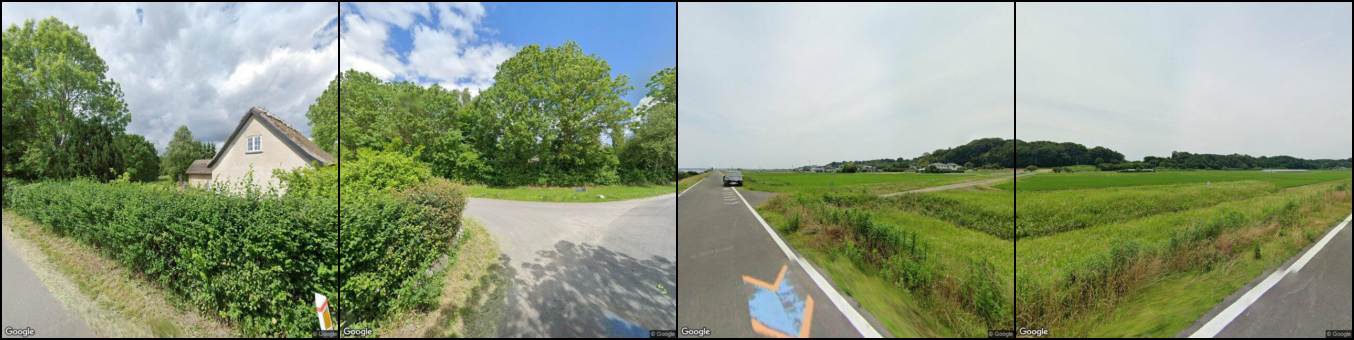

Batch 1:
  image_stacks.shape: torch.Size([8, 4, 3, 336, 336])
  Number of panoramas: 8
  Sample location: lat=10.507369, lon=104.512331


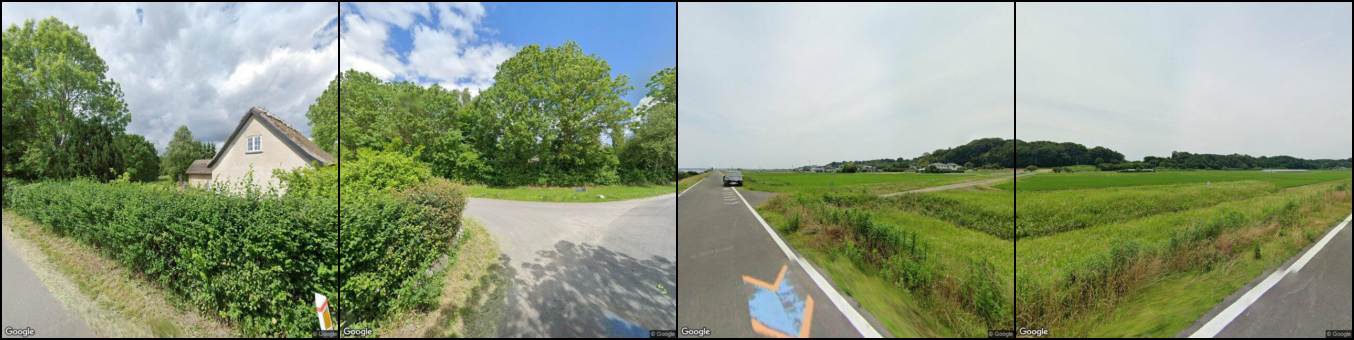


✅ PanoramaIterableDataset works perfectly for 4-image panoramas!


In [12]:
# SOLUTION 2: Use PanoramaIterableDataset (yields 4-image stacks per location)
from backend.data import PanoramaIterableDataset
import torchvision.transforms as T

# Need to add pano_id or use location_id as pano_id
df_for_pano = df_filtered.copy()
if 'pano_id' not in df_for_pano.columns:
    df_for_pano['pano_id'] = df_for_pano['location_id']

# Define a proper transform that returns tensors
pano_transform = T.Compose([
    T.Resize(336),
    T.ToTensor(),
])

# Create panorama dataset (yields stacked 4-image tensors)
pano_dataset = PanoramaIterableDataset(
    df=df_for_pano.head(400),  # 100 locations
    tiles_per_pano=4,
    order_cols=['heading'],    # Sort by heading to ensure consistent order
    transform=pano_transform   # tensorizing transform
)

print(f"Panorama dataset size: {len(pano_dataset)} panoramas")

# Test with DataLoader
# Use single-process loading to avoid pickling issues with pandas objects on some platforms.
pano_loader = DataLoader(
    pano_dataset,
    batch_size=8,              # 8 panoramas per batch
    num_workers=0,             # avoid PicklingError in workers
    pin_memory=False,
    persistent_workers=False,  # must be False when num_workers=0
)

for batch_idx, (image_stacks, targets) in enumerate(pano_loader):
    print(f"Batch {batch_idx}:")
    print(f"  image_stacks.shape: {image_stacks.shape}")  # Should be (8, 4, 3, 336, 336)
    print(f"  Number of panoramas: {len(targets['pano_id'])}")
    print(f"  Sample location: lat={targets['lat'][0]}, lon={targets['lon'][0]}")
    
    # Visualize first panorama grid
    grid = torchvision.utils.make_grid(image_stacks[0], nrow=4, normalize=True)
    display(F.to_pil_image(grid.cpu()))

    if batch_idx >= 1:
        break

print("\n✅ PanoramaIterableDataset works perfectly for 4-image panoramas!")

## Summary of Fixes

### Root Causes Identified:

1. **TypeError (`None` in batch)**: The `GeoImageIterableDataset.__iter__()` method used `continue` when image loading failed, which **skipped samples without yielding anything**, causing mismatched batch sizes and `None` values during collation.

1. **3 vs 4 images per location**: Your S3 data has **incomplete panoramas** - some locations are missing one of the 4 heading images (0°, 90°, 180°, 270°).

### Applied Fixes:

1. **Fixed `backend/data.py`**:

   - Changed `continue` to yield a **placeholder black image** when loading fails
   - Added `heading` field to target dict
   - Prevents `None` values from entering the DataLoader

1. **Best Practice - Filter incomplete data**:

   - Pre-filter DataFrame to only include locations with exactly 4 headings
   - Ensures data quality before training

1. **Alternative - Use `PanoramaIterableDataset`**:

   - Groups 4 images per location into a single (4, C, H, W) tensor
   - Automatically handles panorama grouping and sorting
   - Perfect for models that expect multi-view inputs

### Recommendations:

- **Use Solution 1** (filtered data) for single-image training
- **Use Solution 2** (`PanoramaIterableDataset`) for multi-view/panorama training
- **Investigate S3 data** to understand why some locations have only 3 images
- Consider re-uploading missing images or removing incomplete locations from your dataset

Batch 0: images.shape=torch.Size([64, 3, 336, 336]), lat.shape=torch.Size([64]), lon.shape=torch.Size([64])
{'lat': tensor([ 39.3364,  39.3364,  39.3364,  39.3364, -35.9386, -35.9386, -35.9386,
        -35.9386,  57.1004,  57.1004,  57.1004,  57.1004,  41.7681,  41.7681,
         41.7681,  41.7681,  22.1990,  22.1990,  22.1990,  22.1990,  47.1256,
         47.1256,  47.1256,  47.1256,  32.2631,  32.2631,  32.2631,  32.2631,
         40.9058,  40.9058,  40.9058,  40.9058,  35.9785,  35.9785,  35.9785,
         35.9785,  12.7437,  12.7437,  12.7437,  12.7437,  54.4767,  54.4767,
         54.4767,  54.4767,  61.0175,  61.0175,  61.0175,  61.0175,  36.5029,
         36.5029,  36.5029,  36.5029,  26.9519,  26.9519,  26.9519,  26.9519,
         38.6064,  38.6064,  38.6064,  38.6064,  49.5829,  49.5829,  49.5829,
         49.5829], dtype=torch.float64), 'lon': tensor([ 20.6097,  20.6097,  20.6097,  20.6097, 146.9025, 146.9025, 146.9025,
        146.9025,  26.2800,  26.2800,  26.2800,  26.2800

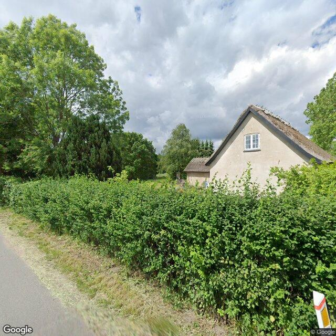

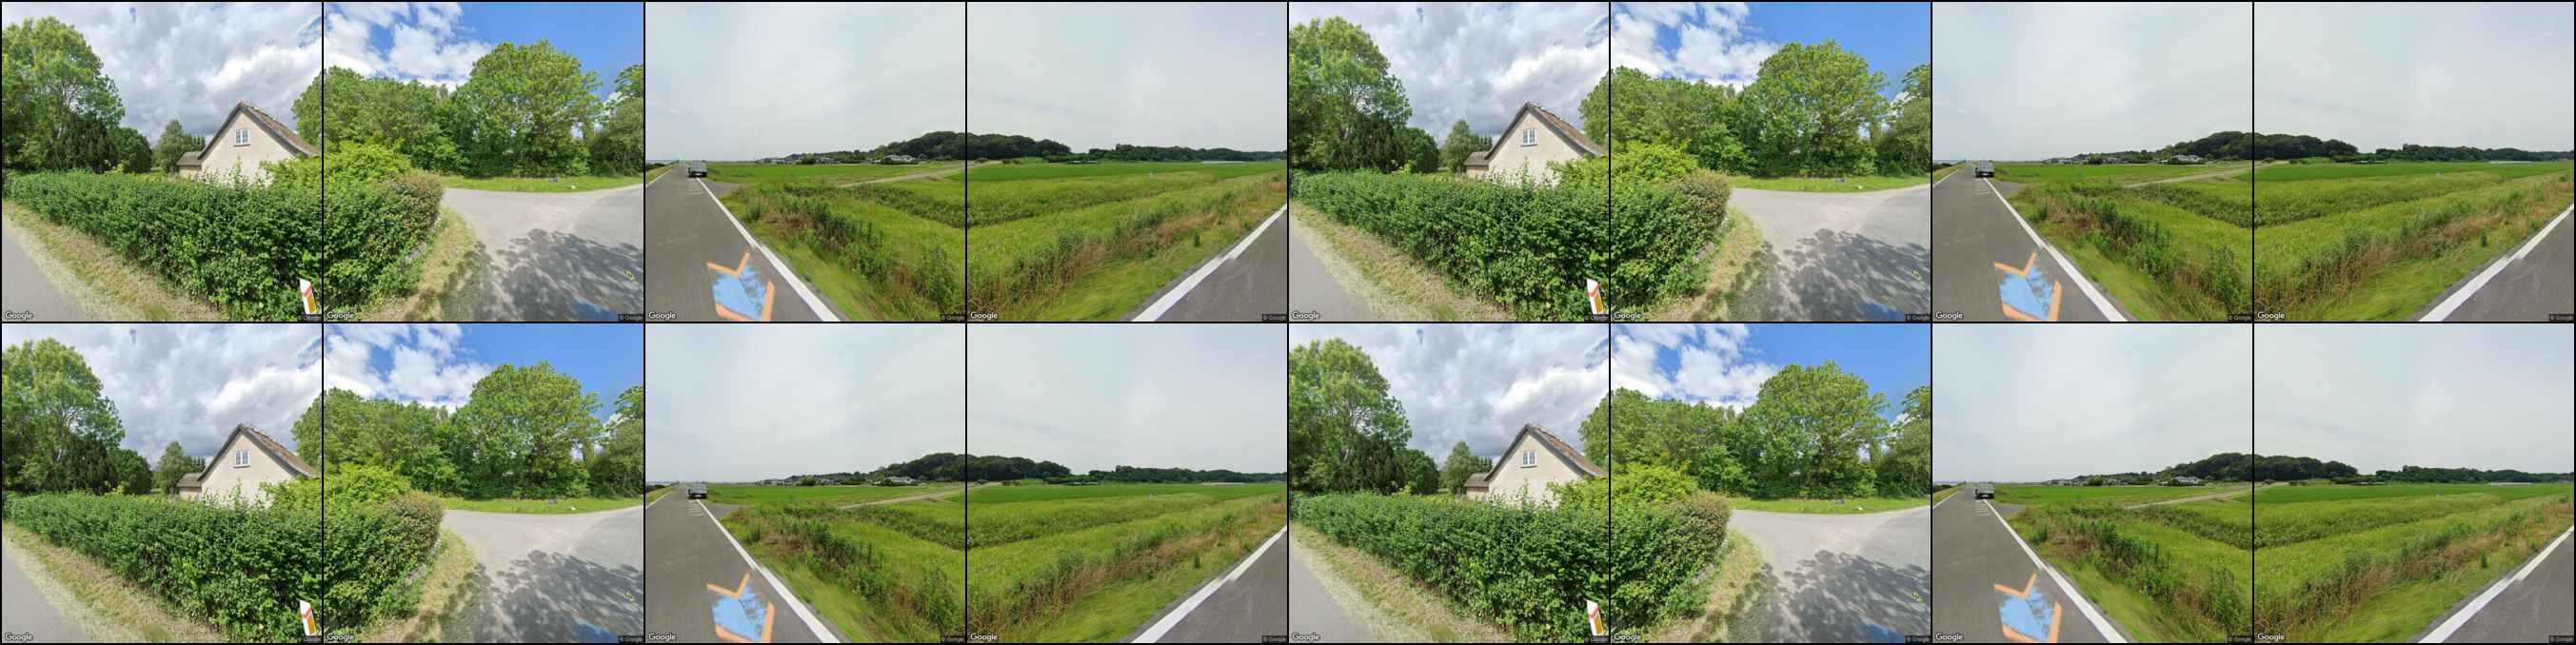

In [13]:
for batch_idx, (images, targets) in enumerate(loader):
    # images: [B, C, H, W], targets: dict of lists/tensors (collated)
    # Example: Make coords tensor
    lat = torch.tensor([float(x) for x in targets["lat"]], dtype=torch.float32)
    lon = torch.tensor([float(x) for x in targets["lon"]], dtype=torch.float32)
    print(f"Batch {batch_idx}: images.shape={images.shape}, lat.shape={lat.shape}, lon.shape={lon.shape}")
    print(targets)

    # Visualize one image from the batch (targets is a dict, not an image)
    pil_img = F.to_pil_image(images[0].cpu())  # first sample in batch
    display(pil_img)

    # Alternatively, visualize a grid of the first 16 images:
    grid = torchvision.utils.make_grid(images[:16].cpu(), nrow=8, normalize=True)
    display(F.to_pil_image(grid))

    break

# Generate Dataset for ProtoRefiner

This section shows how to create a Hugging Face Dataset from your S3 data that's compatible with the ProtoRefiner model.

The dataset needs:

- **embedding**: CLIP embeddings (shape: N x embedding_dim or N x 4 x embedding_dim for 4 headings)
- **labels**: [longitude, latitude] coordinates (shape: N x 2)
- Row indices must match the indices in your proto_df.csv

In [14]:
import numpy as np
from datasets import Dataset, DatasetDict
from PIL import Image
import io
import boto3
from tqdm import tqdm
import torch

# Initialize S3 client (uses your AWS credentials)
s3_client = boto3.client('s3', region_name='eu-north-1')

/Users/daniel/Documents/NTNU/Cogito/geoguessr-ai/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# Load your S3 snapshot dataframe
df_snapshot = load_latest_snapshot_df()

# IMPORTANT: Group by location_id to get all 4 headings per location
# This creates one row per location with 4 images (headings: 0, 90, 180, 270)
df_grouped = df_snapshot.groupby('location_id').agg({
    'lat': 'first',
    'lon': 'first', 
    'image_path': list,  # List of 4 S3 paths
    'heading': list      # List of headings [0, 90, 180, 270]
}).reset_index()

# Keep only locations with all 4 headings
df_grouped = df_grouped[df_grouped['heading'].apply(len) == 4]

print(f"Total locations with 4 headings: {len(df_grouped)}")
df_grouped.head()

Total locations with 4 headings: 105195


location_id        lat         lon  \
0  00003de7dc43  39.336386   20.609662   
1  0000726d0862 -35.938561  146.902454   
2  000102b2049d  57.100408   26.280020   
3  000139218c8a  41.768064  -80.246370   
4  0002064381ce  22.198995  114.022638   

                                          image_path            heading  
0  [s3://cogito-geoguessr/v1/images/location_id=0...  [0, 90, 180, 270]  
1  [s3://cogito-geoguessr/v1/images/location_id=0...  [0, 90, 180, 270]  
2  [s3://cogito-geoguessr/v1/images/location_id=0...  [0, 90, 180, 270]  
3  [s3://cogito-geoguessr/v1/images/location_id=0...  [0, 90, 180, 270]  
4  [s3://cogito-geoguessr/v1/images/location_id=0...  [0, 90, 180, 270]

In [16]:
# Load a CLIP model to generate embeddings
# You can use OpenAI's CLIP or any other vision encoder
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

print(f"CLIP model loaded on {device}")
print(f"Embedding dimension: {model.visual.output_dim}")

ModuleNotFoundError: No module named 'clip'

In [ ]:
def download_and_embed_images(s3_paths, bucket='cogito-geoguessr'):
    """
    Download 4 images from S3 and generate CLIP embeddings.
    
    Args:
        s3_paths: List of 4 S3 URIs (one per heading)
        bucket: S3 bucket name
    
    Returns:
        embeddings: Tensor of shape (4, embedding_dim) for 4 headings
    """
    embeddings = []
    
    for s3_uri in s3_paths:
        # Parse s3://bucket/key
        key = s3_uri.replace(f"s3://{bucket}/", "")
        
        # Download image from S3
        response = s3_client.get_object(Bucket=bucket, Key=key)
        image_data = response['Body'].read()
        
        # Load and preprocess image
        image = Image.open(io.BytesIO(image_data)).convert('RGB')
        image_tensor = preprocess(image).unsqueeze(0).to(device)
        
        # Generate CLIP embedding
        with torch.no_grad():
            embedding = model.encode_image(image_tensor)
            embedding = embedding / embedding.norm(dim=-1, keepdim=True)  # Normalize
        
        embeddings.append(embedding.cpu().squeeze(0))
    
    # Stack to shape (4, embedding_dim)
    return torch.stack(embeddings)


# Test with one location
test_paths = df_grouped.iloc[0]['image_path']
test_embedding = download_and_embed_images(test_paths)
print(f"Test embedding shape: {test_embedding.shape}")  # Should be (4, 512) for CLIP ViT-B/32

In [ ]:
# Generate embeddings for all locations (this will take time!)
# For testing, let's start with a subset
NUM_SAMPLES = 1000  # Adjust this - use len(df_grouped) for full dataset

embeddings_list = []
labels_list = []

for idx in tqdm(range(min(NUM_SAMPLES, len(df_grouped))), desc="Generating embeddings"):
    row = df_grouped.iloc[idx]
    
    try:
        # Get embeddings for 4 headings
        embedding = download_and_embed_images(row['image_path'])
        embeddings_list.append(embedding.numpy())
        
        # Store labels as [longitude, latitude] - IMPORTANT ORDER!
        labels_list.append([row['lon'], row['lat']])
        
    except Exception as e:
        print(f"Error processing index {idx}: {e}")
        continue

# Convert to numpy arrays
embeddings_array = np.array(embeddings_list)  # Shape: (N, 4, embedding_dim)
labels_array = np.array(labels_list)          # Shape: (N, 2)

print(f"Embeddings shape: {embeddings_array.shape}")
print(f"Labels shape: {labels_array.shape}")

In [ ]:
# Create Hugging Face Dataset compatible with ProtoRefiner
dataset_dict = DatasetDict({
    'train': Dataset.from_dict({
        'embedding': embeddings_array,  # Shape: (N, 4, 512)
        'labels': labels_array,          # Shape: (N, 2) - [lon, lat]
    })
})

# Verify structure
print("Dataset structure:")
print(dataset_dict)
print(f"\nFirst sample embedding shape: {dataset_dict['train'][0]['embedding'].shape}")
print(f"First sample labels: {dataset_dict['train'][0]['labels']}")  # Should be [lon, lat]

In [ ]:
# Save the dataset to disk for later use
DATASET_SAVE_PATH = "data/embeddings/geoguessr_dataset"
dataset_dict.save_to_disk(DATASET_SAVE_PATH)
print(f"Dataset saved to {DATASET_SAVE_PATH}")

## Load and Use with ProtoRefiner

Now you can load this dataset and use it with ProtoRefiner

In [ ]:
# Load the saved dataset
from datasets import DatasetDict

loaded_dataset = DatasetDict.load_from_disk(DATASET_SAVE_PATH)
print("Loaded dataset:")
print(loaded_dataset)

# Now you can use this with ProtoRefiner
# from models.proto_refiner import ProtoRefiner
# 
# refiner = ProtoRefiner(
#     dataset_path=DATASET_SAVE_PATH,
#     proto_path="data/geocells/proto_df.csv",
#     topk=5,
#     max_refinement=1000,
#     temperature=1.6
# )

## Important: Align Dataset Indices with proto_df

The indices in `proto_df.csv` must match row indices in your dataset!

In [ ]:
# Read proto_df to check what indices it expects
import pandas as pd
proto_df = pd.read_csv("data/geocells/proto_df.csv")
print("Proto_df structure:")
print(proto_df.head())
print(f"\nTotal geocells: {len(proto_df)}")

# Parse the indices column (it's stored as string, needs to be evaluated)
import ast
proto_df['indices_parsed'] = proto_df['indices'].apply(ast.literal_eval)

# Check what indices are referenced
all_indices = set()
for idx_list in proto_df['indices_parsed']:
    all_indices.update(idx_list)

print(f"\nTotal unique image indices referenced in proto_df: {len(all_indices)}")
print(f"Min index: {min(all_indices)}, Max index: {max(all_indices)}")
print(f"\nYour dataset has {len(dataset_dict['train'])} samples")

# WARNING: If max index > dataset length, ProtoRefiner will fail!
if max(all_indices) >= len(dataset_dict['train']):
    print(f"\n⚠️ WARNING: proto_df references indices up to {max(all_indices)}, "
          f"but your dataset only has {len(dataset_dict['train'])} samples!")
    print("You need to generate embeddings for ALL images referenced in proto_df.")

## Alternative: Generate proto_df from Your Dataset

If you want to regenerate proto_df.csv to match your current dataset, use the GeocellManager

In [ ]:
# Use GeocellManager to generate a new proto_df that matches your dataset indices
from data.geocells.geocell_manager import GeocellManager

# Load geocells
geocell_path = "data/geocells/finished_geocells"
manager = GeocellManager(geocell_path)

# This will create a new proto_df.csv aligned with your point data
# You'll need to map your dataset indices to the geocell assignments
# For now, let's see the structure
print(f"Number of geocells: {manager.get_num_geocells()}")
print(f"Sample point info:")
for i, (hash_key, info) in enumerate(list(manager.point_info_dict.items())[:5]):
    print(f"  {info}")

In [ ]:
# Optional: custom collate that drops bad samples defensively
from torch.utils.data.dataloader import default_collate

def safe_collate(batch):
    # filter out any Nones defensively
    batch = [b for b in batch if b is not None]
    # also drop items where tensor is None
    batch = [b for b in batch if (b is not None and b[0] is not None and b[1] is not None)]
    if not batch:
        return None
    return default_collate(batch)

# Example usage:
# loader = DataLoader(dataset, batch_size=64, num_workers=2, collate_fn=safe_collate)
